In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)

from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
tf.compat.v1.disable_v2_behavior
from tensorflow import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
data = os.path.join('C:/Users/asus/Documents/HAM10000/HAM10000_images_part_1')

In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data, '*.jpg'))}
# imageid_path_dict

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
metadata = os.path.join('C:/Users/asus/Documents/HAM10000/csv')
skin_df = pd.read_csv(os.path.join(metadata, 'HAM10000_metadata.csv'))
skin_df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


In [ ]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df.sample(6)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
9725,HAM_0004376,ISIC_0024843,akiec,histo,70.0,female,face,C:/Users/asus/Documents/HAM10000/HAM10000_imag...,Actinic keratoses,0
6059,HAM_0003024,ISIC_0024768,nv,follow_up,35.0,female,trunk,C:/Users/asus/Documents/HAM10000/HAM10000_imag...,Melanocytic nevi,4
4540,HAM_0001659,ISIC_0026564,nv,follow_up,35.0,male,lower extremity,C:/Users/asus/Documents/HAM10000/HAM10000_imag...,Melanocytic nevi,4
3817,HAM_0004625,ISIC_0029346,nv,follow_up,40.0,male,upper extremity,C:/Users/asus/Documents/HAM10000/HAM10000_imag...,Melanocytic nevi,4
7914,HAM_0000443,ISIC_0034271,nv,histo,35.0,female,back,C:/Users/asus/Documents/HAM10000/HAM10000_imag...,Melanocytic nevi,4
8910,HAM_0007176,ISIC_0032144,nv,histo,30.0,male,lower extremity,C:/Users/asus/Documents/HAM10000/HAM10000_imag...,Melanocytic nevi,4


In [ ]:
skin_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0003789,ISIC_0027419,nv,histo,male,back,C:/Users/asus/Documents/HAM10000/HAM10000_imag...,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


<AxesSubplot:>

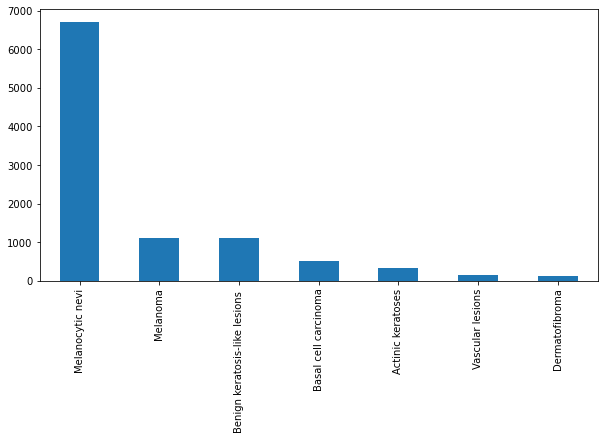

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((80, 100))))

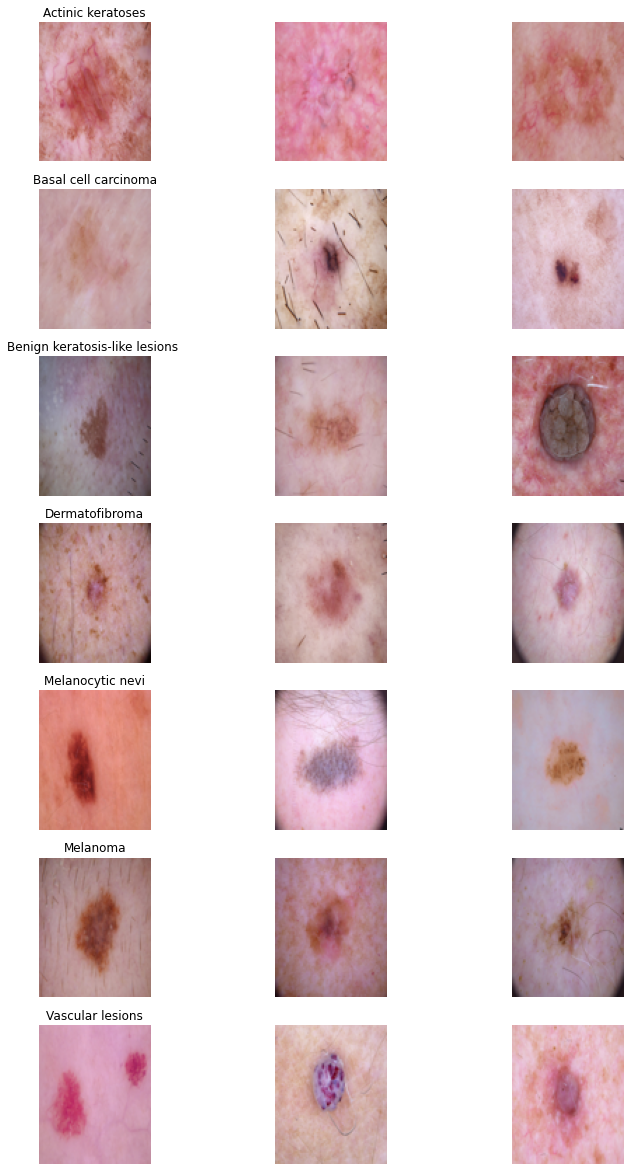

In [ ]:
#Image Sampling
n_samples = 3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
#Organizing dataset - input and output
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [ ]:
#Traing and testing sampling
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20)

In [ ]:
#Normalization - the x_train, x_test by substracting from theor mean values and then dividing by thier standard deviation.
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#Splitting training into Train and Validate sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1)

# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(80, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(80, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(80, 100, 3))

In [ ]:
from tensorflow.keras.layers import AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# Set the CNN model
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(BatchNormalization())

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

##############################
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 batch_normalization (BatchN  (None, 75, 100, 32)      128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 batch_normalization_1 (Batc  (None, 75, 100, 32)      128       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 37, 50, 32)       0         
 ooling2D)                                                       
                                                        

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
# Define the optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer = SGD(lr=0.001, momentum=15, decay=0.0, nesterov=False)
#Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10)

In [ ]:
datagen.fit(x_train)

In [ ]:
# ## Fit the model
# epochs = 20
# batch_size = 20
# #history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (x_validate,y_validate))

In [ ]:
# loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
# loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
# print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
# print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn import metrics

In [ ]:
from sklearn import metrics
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4',
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

In [ ]:
from tensorflow.compat.v1.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

input_shape = (80, 100, 3)

num_labels = 7

base_model = InceptionV3(include_top = False, input_shape = input_shape,pooling = 'avg',
                         weights = 'imagenet')
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = True

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                 903       
                                                                 
Total params: 22,065,959
Trainable params: 22,031,527
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
optimizer = Adam (learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=5e-7, amsgrad=False)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
y_train = np.argmax(y_train, axis = 1)

In [ ]:
y_validate = np.argmax(y_validate, axis = 1)

In [ ]:
epochs = 20
batch_size = 20
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/20
360/360 [==============================] - 356s 955ms/step - loss: 3.3986 - accuracy: 0.6465 - val_loss: 1.8964 - val_accuracy: 0.6845
Epoch 2/20
360/360 [==============================] - 331s 921ms/step - loss: 1.5397 - accuracy: 0.6616 - val_loss: 1.1617 - val_accuracy: 0.6995
Epoch 3/20
360/360 [==============================] - 338s 940ms/step - loss: 1.1882 - accuracy: 0.6640 - val_loss: 1.0367 - val_accuracy: 0.6908
Epoch 4/20
360/360 [==============================] - 335s 930ms/step - loss: 1.1289 - accuracy: 0.6599 - val_loss: 0.9829 - val_accuracy: 0.6845
Epoch 5/20
360/360 [==============================] - 335s 930ms/step - loss: 1.0417 - accuracy: 0.6661 - val_loss: 0.9318 - val_accuracy: 0.6883
Epoch 6/20
360/360 [==============================] - 329s 913ms/step - loss: 1.0369 - accuracy: 0.6605 - val_loss: 0.9436 - val_accuracy: 0.6933
Epoch 7/20
360/360 [==============================] - 347s 963ms/step - loss: 1.0287 - accuracy: 0.6611 - val_loss: 1.3391 -

In [ ]:
y_test = np.argmax(y_test, axis = 1)

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
#isicskinlesion@gmail.com

Validation: accuracy = 0.684539  ;  loss_v = 2.638494
Test: accuracy = 0.688967  ;  loss = 2.089651


In [ ]:
model.save('InceptionV3.h5')

In [ ]:
from tensorflow.keras.applications.xception import Xception

input_shape = (80, 100, 3)

num_labels = 7

base_model = Xception(include_top = False, input_shape = input_shape,pooling = 'avg',
                         weights = 'imagenet')
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = True

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_11 (Dropout)        (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 7)                 903       
                                                                 
Total params: 21,124,655
Trainable params: 21,070,127
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#Splitting training into Train and Validate sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1)

# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(80, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(80, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(80, 100, 3))

In [ ]:
epochs =  28
batch_size = 20
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_steps=(x_validate.shape[0] // batch_size),
                    callbacks=[learning_rate_reduction])

Epoch 1/28
360/360 [==============================] - 730s 2s/step - loss: 4.9281 - acc: 0.6552 - val_loss: 3.6691 - val_acc: 0.6708 - lr: 1.0000e-04
Epoch 2/28
360/360 [==============================] - 782s 2s/step - loss: 2.9228 - acc: 0.6765 - lr: 1.0000e-04
Epoch 3/28
360/360 [==============================] - 764s 2s/step - loss: 1.9238 - acc: 0.6828 - lr: 1.0000e-04
Epoch 4/28
360/360 [==============================] - 668s 2s/step - loss: 1.4272 - acc: 0.7017 - lr: 1.0000e-04
Epoch 5/28
360/360 [==============================] - 670s 2s/step - loss: 1.1623 - acc: 0.7163 - lr: 1.0000e-04
Epoch 6/28
360/360 [==============================] - 671s 2s/step - loss: 1.0190 - acc: 0.7234 - lr: 1.0000e-04
Epoch 7/28
360/360 [==============================] - 669s 2s/step - loss: 0.9438 - acc: 0.7271 - lr: 1.0000e-04
Epoch 8/28
360/360 [==============================] - 668s 2s/step - loss: 0.8828 - acc: 0.7405 - lr: 1.0000e-04
Epoch 9/28
360/360 [==============================] - 761s 

360/360 [==============================] - 672s 2s/step - loss: 0.6242 - acc: 0.8075 - lr: 1.0000e-04
Epoch 26/28
360/360 [==============================] - 668s 2s/step - loss: 0.6065 - acc: 0.8145 - lr: 1.0000e-04
Epoch 27/28
360/360 [==============================] - 668s 2s/step - loss: 0.5914 - acc: 0.8191 - lr: 1.0000e-04
Epoch 28/28
360/360 [==============================] - 670s 2s/step - loss: 0.5914 - acc: 0.8178 - lr: 1.0000e-04


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

26/26 [==============================] - 9s 364ms/step - loss: 0.8001 - acc: 0.7481
Validation: accuracy = 0.748130  ;  loss_v = 0.800085
Test: accuracy = 0.760359  ;  loss = 0.806127


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

26/26 [==============================] - 12s 362ms/step


C:\Users\asus\Downloads\anacnd\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\Downloads\anacnd\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asus\Downloads\anacnd\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier <keras.engine.sequential.Sequential object at 0x000002867FCD8C70>:
              precision    recall  f1-score   support

     class 0       0.38      0.19      0.25        16
     class 1       0.51      0.64      0.57        47
     class 2       0.63      0.30      0.41        90
     class 3       0.00      0.00      0.00        11
     class 4       0.83      0.92      0.88       538
     class 5       0.43      0.38      0.40        88
     class 6       0.53      0.83      0.65        12

    accuracy                           0.75       802
   macro avg       0.47      0.47      0.45       802
weighted avg       0.72      0.75      0.73       802




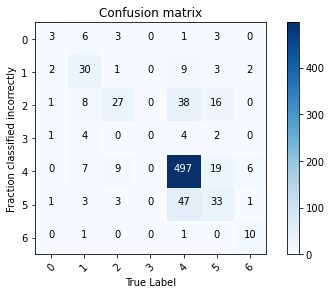

In [ ]:
from sklearn import metrics
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4',
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

In [ ]:
model.save('VGG19.h5')

In [ ]:
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_validate.npy', x_validate)
np.save('y_validate.npy', x_validate)
np.save('x_test.npy', x_test)
np.save('y_test.npy', x_test)

In [ ]:
#hamdatates@gmail.com
#datahamset@gmail.com

In [ ]:
import os
from glob import glob
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
### It is a typical deep Convolutional Neural Network (CNN) design with numerous layers, and the abbreviation VGG stands for Visual Geometry Group. The term “deep” describes the number of layers, with VGG-16 or VGG-19 having 16 or 19 convolutional layers, respectively.

In [ ]:
y_train = np.load("y_train.npy")

In [ ]:
X_train = np.load("x_train.npy")

In [ ]:
X_val = np.load("x_validate.npy")

In [ ]:
y_val = np.load("y_validate.npy")

In [ ]:
X_train.shape, X_val.shape